In [157]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, minmax_scale, scale
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [92]:
#Preparar los datos como lo haciamos nosotros
seed = 42
DATASETX = "./data/prep/HotelReservationsPreparedCleanX.csv"
DATASETY = "./data/prep/HotelReservationsY.csv"
df_x = pd.read_csv(DATASETX)
df_y = pd.read_csv(DATASETY)
df = pd.concat([df_x, df_y], axis=1)
df = shuffle(df, random_state=seed)

In [99]:
#Preparar los datos como el profe
ATT_FILE = "./data/prep/HotelReservationsPreparedCleanX.csv"
LABEL_FILE = "./data/prep/HotelReservationsY.csv"

TRAIN_RATE=0.8

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2)

X_train = attributes.values[:n_train]
y_train = label.values[:n_train]

X_val = attributes.values[n_train:n_train+n_dev]
y_val = label.values[n_train:n_train+n_dev]

In [93]:
# Dividimos el dataframe en train y test en una proporción de 80/20
X_train, X_test, y_train, y_test = train_test_split(df, df["booking_status"], test_size=0.2, random_state=seed)

# Dividimos el conjunto de prueba en test y validation en una proporción de 50/50
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [135]:
INPUTS = X_train.shape[1]
OUTPUTS = 1
NUM_TRAINING_EXAMPLES = int(round(X_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (X_val.shape[0]/1))
print(INPUTS)

16


In [228]:
#Inicializar hiperparámetros
n_epochs = 1000
lr = 0.1
batch_size = 512
n_neurons_per_hlayer = [1024, 512, 256, 128, 64, 32]

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
lr,
decay_steps=100000,
decay_rate=0.96,
staircase=True)

In [233]:
#Construir el modelo
model = keras.Sequential(name="DeepFeedforward")

model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

for neurons in n_neurons_per_hlayer:
  model.add(keras.layers.Dense(neurons))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation("sigmoid"))
  model.add(keras.layers.Dropout(rate=0.75))

model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "DeepFeedforward"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_164 (Dense)           (None, 1024)              17408     
                                                                 
 batch_normalization_124 (B  (None, 1024)              4096      
 atchNormalization)                                              
                                                                 
 activation_116 (Activation  (None, 1024)              0         
 )                                                               
                                                                 
 dropout_88 (Dropout)        (None, 1024)              0         
                                                                 
 dense_165 (Dense)           (None, 512)               524800    
                                                                 
 batch_normalization_125 (B  (None, 512)           

In [234]:
#Compilar el modelo
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)
#opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=opt,
              metrics=["binary_accuracy"])

In [235]:
#Entrenar el modelo
import time
start = time.perf_counter()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(X_val, y_val))
print (time.perf_counter() - start)


Epoch 1/1000
57/57 [==============================] - 8s 54ms/step - loss: 0.6612 - binary_accuracy: 0.6551 - val_loss: 0.6359 - val_binary_accuracy: 0.6678
Epoch 2/1000
57/57 [==============================] - 3s 46ms/step - loss: 0.6335 - binary_accuracy: 0.6739 - val_loss: 0.6374 - val_binary_accuracy: 0.6678
Epoch 3/1000
57/57 [==============================] - 3s 46ms/step - loss: 0.6343 - binary_accuracy: 0.6739 - val_loss: 0.6357 - val_binary_accuracy: 0.6678
Epoch 4/1000
57/57 [==============================] - 3s 47ms/step - loss: 0.6326 - binary_accuracy: 0.6739 - val_loss: 0.6360 - val_binary_accuracy: 0.6678
Epoch 5/1000
57/57 [==============================] - 3s 46ms/step - loss: 0.6320 - binary_accuracy: 0.6739 - val_loss: 0.6364 - val_binary_accuracy: 0.6678
Epoch 6/1000
57/57 [==============================] - 3s 47ms/step - loss: 0.6325 - binary_accuracy: 0.6739 - val_loss: 0.6358 - val_binary_accuracy: 0.6678
Epoch 7/1000
57/57 [==============================] - 3s 4

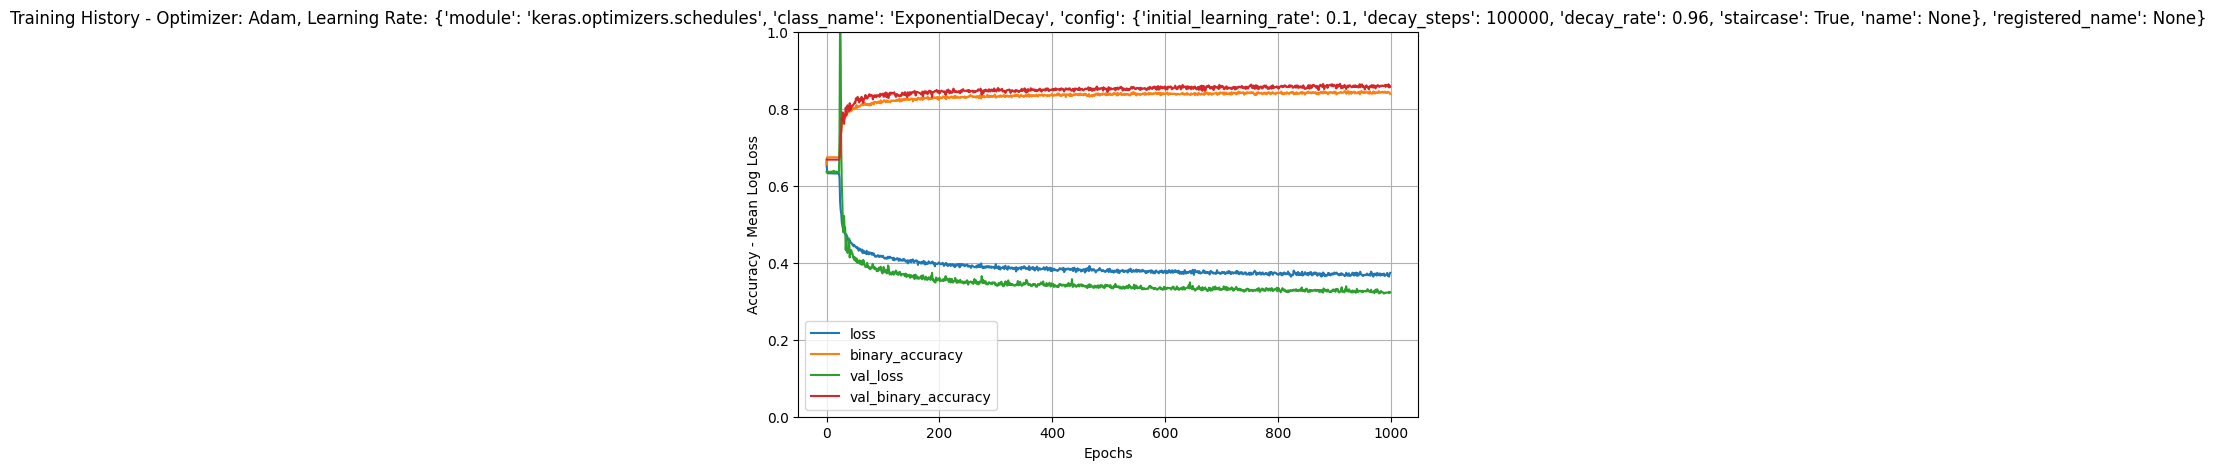

In [236]:
#Obtener los resultados
title = f"Training History - Optimizer: {type(opt).__name__}, Learning Rate: {opt.get_config()['learning_rate']}"
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5), title=title)
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig(f"./images/loss{n_neurons_per_hlayer}_{type(opt).__name__}_sigmoidDropOut075Scheduler.png")
plt.show()

In [191]:
print ("Accuracy for the training set: ", results.binary_accuracy.values[-1:][0])
print ("Accuracy for the development test set: ", results.val_binary_accuracy.values[-1:][0])

Accuracy for the training set:  0.976047694683075
Accuracy for the development test set:  0.8549765944480896


In [179]:
#Validar el modelo
dev_predictions=model.predict(X_val).round(2)
dev_predictions[:20]

114/114 [==============================] - 1s 3ms/step


array([[0.41],
       [0.41],
       [0.41],
       [0.41],
       [0.5 ],
       [0.41],
       [0.41],
       [0.41],
       [0.41],
       [0.97],
       [0.41],
       [0.48],
       [0.81],
       [0.41],
       [0.41],
       [0.41],
       [0.41],
       [0.41],
       [0.42],
       [0.41]], dtype=float32)

In [180]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [181]:
y_val[:20]

array([[0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1]], dtype=int64)

In [182]:
print(dev_rounded_predictions.shape)
print(y_val.shape)

(3627, 1)
(3627, 1)


In [183]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(y_val,1))
print (dev_correct_predictions[:30])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [184]:
from collections import Counter
Counter (dev_correct_predictions)

Counter({True: 3627})

TEST FINAL

In [148]:
n_final_test = n_instances-n_train-n_dev

x_final_test = attributes.values[n_train+n_dev:n_instances]
t_final_test = label.values[n_train+n_dev:n_instances]

In [151]:
model.evaluate(x_final_test, t_final_test)

114/114 [==============================] - 0s 3ms/step - loss: 0.6909 - binary_accuracy: 0.8379


[0.6908889412879944, 0.8378825187683105]

In [153]:
test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(t_final_test,1))
test_correct_predictions[:30]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [154]:
from collections import Counter
final_test_prediction_results=Counter(test_correct_predictions)
final_test_prediction_results

Counter({True: 3627})

In [155]:
final_test_prediction_results[True]/sum(final_test_prediction_results.values())

1.0

In [158]:
test_sparse_predictions = np.argmax (test_predictions,axis=1)
test_sparse_targets = np.argmax(t_final_test, axis=1)
print('Confusion Matrix')
c_m=pd.DataFrame(confusion_matrix(test_sparse_predictions,test_sparse_targets),columns=['True_Cheap', 'True_Average'])
c_m.insert(0,'Classes',['Pred_Cheap', 'Pred_Average', 'Pred_Expensive'])
c_m['Sum']=c_m.sum(axis=1, numeric_only=True)
c_m

Confusion Matrix


ValueError: Shape of passed values is (1, 1), indices imply (1, 3)

In [161]:
print('Classification Report')
classes = ['Cheap']
print(classification_report(test_sparse_targets, test_sparse_predictions, target_names=classes))

Classification Report
              precision    recall  f1-score   support

       Cheap       1.00      1.00      1.00      3627

    accuracy                           1.00      3627
   macro avg       1.00      1.00      1.00      3627
weighted avg       1.00      1.00      1.00      3627

